In [1]:
import time
import jax
import jax.numpy as jnp
from jax import lax
import matplotlib.pyplot as plt
from functools import partial
from typing import Tuple, Callable

In [2]:
def timer(func):
    """
    decorator to measure elapsed time

    Parameters
    -----------
    func: function
        function to be decorated
    """

    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{func.__name__} took {(end - start) * 1000:.2f} ms")
        return result

    return wrapper


@jax.jit
def f_sys(y: jnp.ndarray, t: float, b: float, c: float) -> jnp.ndarray:
    """
    System of ODEs representing a damped pendulum.

    Args:
        y: State vector [theta, omega]
        t: Time (unused but kept for consistency)
        b: Damping coefficient
        c: Pendulum parameter

    Returns:
        Array containing the derivatives [dtheta/dt, domega/dt]
    """
    return jnp.array([y[1], -b * y[1] - c * jnp.sin(y[0])])


@jax.jit
def rk4_step(y: jnp.ndarray, t: float, dt: float, b: float, c: float) -> jnp.ndarray:
    """
    Perform one step of the RK4 method.

    Args:
        y: Current state
        t: Current time
        dt: Time step
        b: Damping coefficient
        c: Pendulum parameter

    Returns:
        Updated state vector
    """
    k1 = f_sys(y, t, b, c)
    k2 = f_sys(y + 0.5 * dt * k1, t + 0.5 * dt, b, c)
    k3 = f_sys(y + 0.5 * dt * k2, t + 0.5 * dt, b, c)
    k4 = f_sys(y + dt * k3, t + dt, b, c)

    return y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


# add heun scheme
@jax.jit
def heun_step(y: jnp.ndarray, t: float, dt: float, b: float, c: float) -> jnp.ndarray:
    """
    Perform one step of the Heun method.

    Args:
        y: Current state
        t: Current time
        dt: Time step
        b: Damping coefficient
        c: Pendulum parameter
    """
    k1 = f_sys(y, t, b, c)
    k2 = f_sys(y + dt * k1, t + dt, b, c)

    return y + 0.5 * dt * (k1 + k2)


@jax.jit
def solve_pendulum_step(
    carry: Tuple[jnp.ndarray, float], _, dt: float, b: float, c: float
) -> Tuple[Tuple[jnp.ndarray, float], jnp.ndarray]:
    """
    Single step of the solver, designed for use with lax.scan.

    Args:
        carry: Tuple of (state, time)
        _: Unused (required for lax.scan)
        dt: Time step
        b: Damping coefficient
        c: Pendulum parameter

    Returns:
        New carry value and current state
    """
    y, t = carry
    # y_next = rk4_step(y, t, dt, b, c)
    y_next = heun_step(y, t, dt, b, c)
    t_next = t + dt
    return (y_next, t_next), y_next

@timer
def solve_pendulum(
    y0: jnp.ndarray, t_span: jnp.ndarray, b: float, c: float
) -> jnp.ndarray:
    """
    Solve the pendulum ODE system using RK4 method with JAX optimization.

    Args:
        y0: Initial conditions [theta0, omega0]
        t_span: Array of time points
        b: Damping coefficient
        c: Pendulum parameter

    Returns:
        Solution array with shape (len(t_span), 2)
    """
    dt = t_span[1] - t_span[0]
    n_steps = len(t_span) - 1

    # Initialize the solution array with the initial condition
    solution = jnp.zeros((len(t_span), 2))
    solution = solution.at[0].set(y0)

    # Run the simulation using scan
    _, trajectory = lax.scan(
        lambda carry, x: solve_pendulum_step(carry, x, dt, b, c),
        (y0, t_span[0]),
        None,
        length=n_steps,
    )

    # Combine initial condition with trajectory
    solution = solution.at[1:].set(trajectory)

    return solution


def plot_results(t: jnp.ndarray, solution: jnp.ndarray, b: float, c: float):
    """
    Plot the results of the simulation including phase space and energy.

    Args:
        t: Time array
        solution: Solution array from solve_pendulum
        b: Damping coefficient
        c: Pendulum parameter
    """
    # Calculate energy
    kinetic = 0.5 * solution[:, 1] ** 2
    potential = c * (1 - jnp.cos(solution[:, 0]))
    total_energy = kinetic + potential

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    # Plot angle vs time
    axes[0, 0].plot(t, solution[:, 0], "b-", label="θ(t)")
    axes[0, 0].set_xlabel("Time")
    axes[0, 0].set_ylabel("Angle θ")
    axes[0, 0].set_title("Angle vs Time")
    axes[0, 0].grid(True)
    axes[0, 0].legend()

    # Plot angular velocity vs time
    axes[0, 1].plot(t, solution[:, 1], "r-", label="ω(t)")
    axes[0, 1].set_xlabel("Time")
    axes[0, 1].set_ylabel("Angular velocity ω")
    axes[0, 1].set_title("Angular Velocity vs Time")
    axes[0, 1].grid(True)
    axes[0, 1].legend()

    # Plot phase space
    axes[1, 0].plot(solution[:, 0], solution[:, 1], "g-", label="Phase trajectory")
    axes[1, 0].set_xlabel("Angle θ")
    axes[1, 0].set_ylabel("Angular velocity ω")
    axes[1, 0].set_title("Phase Space")
    axes[1, 0].grid(True)
    axes[1, 0].legend()

    # Plot energy
    axes[1, 1].plot(t, kinetic, "b-", label="Kinetic")
    axes[1, 1].plot(t, potential, "r-", label="Potential")
    axes[1, 1].plot(t, total_energy, "g-", label="Total")
    axes[1, 1].set_xlabel("Time")
    axes[1, 1].set_ylabel("Energy")
    axes[1, 1].set_title("System Energy")
    axes[1, 1].grid(True)
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

2024-10-11 17:39:18.700099: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Compiling functions...
solve_pendulum took 395.91 ms

Solving ODE system...
solve_pendulum took 91.11 ms


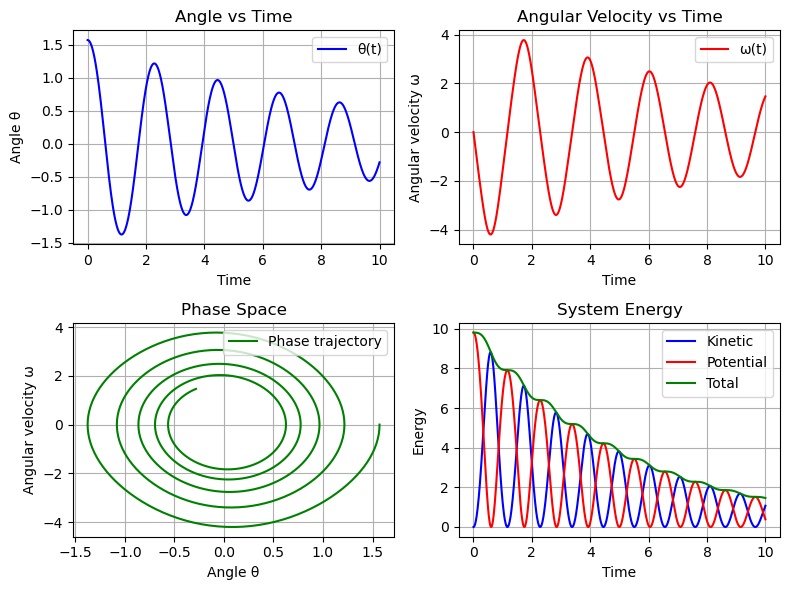


Maximum angle: 1.57 radians
Maximum angular velocity: 3.78 rad/s


In [3]:
# Set parameters
b = 0.2  # damping coefficient
c = 9.81  # gravitational parameter

# Initial conditions: [theta0, omega0]
y0 = jnp.array([jnp.pi/2, 0.0])  # Start at 90 degrees with zero velocity

# Time points
t = jnp.linspace(0, 10, 1000)

# Warm up JIT compilation
print("Compiling functions...")
_ = solve_pendulum(y0, t, b, c)

# Measure performance
print("\nSolving ODE system...")
solution = solve_pendulum(y0, t, b, c)

# Plot results
plot_results(t, solution, b, c)

# Print statistics
print(f"\nMaximum angle: {jnp.max(solution[:, 0]):.2f} radians")
print(f"Maximum angular velocity: {jnp.max(solution[:, 1]):.2f} rad/s")